In [1]:
%load_ext lab_black
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


sns.set(
    # context="talk",
    # font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
import glob
from scipy.optimize import curve_fit

#  Kd Fitting Functions

In [2]:
def binding(Atot, S0, S1, Kd, Btot):
    """
    This is the binding isotherm function for A+B <-> AB that will be fit assuming a titration of A onto constant B.
    Kd = ([A][B])/[AB]
    [Atot] = [A] + [AB]
    [A] = [Atot] - [AB]
    [Btot] = [B] + [AB]
    [B] = [Btot] - [AB]
    Kd = ([Atot] - [AB])([Btot] - [AB])/[AB]
    Kd * [AB] = ([Atot] - [AB])([Btot] - [AB])
    0 = ([Atot] - [AB])([Btot] - [AB]) - Kd * [AB]
    # rearrange into ax^2 + bx + c where [AB] is x, since that is what our response variable is measuring (by change from S0 -> S0 + S1)
    0 = [AB]^2 - ([Atot] + [Btot] + Kd)[AB] + [Atot][Btot]
    # use quadratic formula
    [AB] = (([Atot] + [Btot] + Kd) +/- sqrt(([Atot] + [Btot] + Kd)^2 - 4[Atot][Btot])) / 2
    # The signal we get is the base signal plus the amount of signal possible adjusted by how much signal is being produced
    # Supposing B is what makes the signal (since usually what makes the signal is held constant)
    Signal = Baseline + Amplitude * [AB]/[Btot]
    """

    AB = (Btot + Atot + Kd - np.sqrt((Btot + Atot + Kd) ** 2 - 4 * Btot * Atot)) / 2
    S = S0 + S1 * AB / Btot

    return S


def get_exp(titration_count: int, titration_rate: int, skip: int, x: int) -> dict:
    import numpy as np

    exp = {
        rows: np.arange(i * titration_count + skip, (i + 1) * titration_count)
        for i, rows in enumerate("AB CD EF GH".split())
        if i < x
    }
    return exp


def normalize_array(array):
    import numpy as np

    norm = np.linalg.norm(array)
    return array / norm

# Plot FP grid

  0%|          | 0/6 [00:00<?, ?it/s]

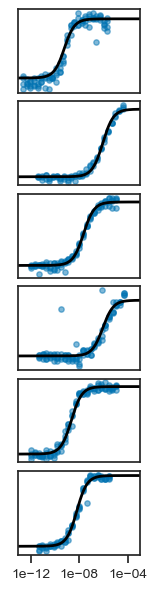

In [10]:
import matplotlib
from matplotlib import rc, font_manager

import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator

matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="FreeSans")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 10})

props = {
    "family": "sans-serif",
    "sans-serif": ["FreeSans"],
    "weight": "normal",
    "size": 10,
}


groups = {
    "cs_074": (
        "/net/expdata/NEO2/flop/20220531_FP_P1_FF74_5h.xlsx",
        2e-6,  # starting_conc
        0.1e-9,  # constant
        0,  # skip
        4,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 0, 4),  # exp
    ),
    "cs_094": (
        "/net/expdata/NEO2/Phil/results/20220516_FP_prod_94ABr2_x2_36uM_1nM_peptide.xlsx",
        36e-6,  # starting_conc
        1e-9,  # constant
        0,  # skip
        3,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 0, 3),  # exp
    ),
    "cs_201": (
        "/net/expdata/NEO2/flop/20220802_FP_P6_201cleavedx4_500pM-peptide_10uM-prot_26h.xlsx",
        10e-6,  # starting_conc
        0.5e-9,  # constant
        0,  # skip
        4,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 0, 4),  # exp
    ),
    "cs_207": (
        "/net/expdata/NEO2/flop/20221118_FP_P2_4xcs207_1nMpeptide_42uMprot_18h.xlsx",
        42e-6,  # starting_conc
        1e-9,  # constant
        0,  # skip
        4,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 0, 4),  # exp
    ),
    "cs_221": (
        "/net/expdata/NEO2/flop/20220803_FP_P1_221x4_100pM-peptide_10uM-prot_37h.xlsx",
        10e-6,  # starting_conc
        0.1e-9,  # constant
        0,  # skip
        4,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 0, 4),  # exp
    ),
    "js_007": (
        "/net/expdata/NEO2/flop/20221119_FP_P1_4xJ7_1nMpeptide_40uMprot_21h.xlsx",
        40e-6,  # starting_conc
        1e-9,  # constant
        4,  # skip
        4,  # x
        24,  # titration_count
        2,  # titration_rate
        get_exp(24, 2, 4, 4),  # exp
    ),
    # "js_109": (
    #     "/net/expdata/NEO2/Phil/results/20221106_FP_P5_prod_JHB_09mA_og1_x4_10uM_1nM_JHB_09mB_peptide_24h.xlsx",
    #     10e-6,  # starting_conc
    #     1e-9,  # constant
    #     0,  # skip
    #     4,  # x
    #     24,  # titration_count
    #     2,  # titration_rate
    #     get_exp(24, 2, 0, 4),  # exp
    # ),
}


cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(
    nrows=len(groups),
    ncols=1,
    sharex=True,
    figsize=(4 * cm, len(groups) * 3 * cm),
    gridspec_kw={"hspace": 0.1},
)
for i, (
    cs,
    (
        file,
        starting_conc,
        constant,
        skip,
        x,
        titration_count,
        titration_rate,
        exp,
    ),
) in enumerate(tqdm(groups.items())):
    # generate titration series
    conc = np.array(
        [starting_conc / (titration_rate**i) for i in range(titration_count)]
    )[skip:]
    # flatten concs and values
    results = pd.read_excel(file, skiprows=6)
    concs, polarizations = [], []
    for k, v in exp.items():
        polarization = results.iloc[v, :]["Polarization"].values
        concs.extend(list(conc))
        polarizations.extend(list(polarization))

    # Fitting subroutine

    # guess the lower bound of the fit from the min value
    s0_guess = 1.1 * np.min(polarizations)
    # guess the upper bound of the fit from the max value
    s1_guess = 0.9 * np.max(polarizations) - s0_guess
    # TODO smarter Kd initialization would find the x value corresponding to the y-value that is closest to (s1-s0)/2
    kd_guess = 1e-8

    param = [s0_guess, s1_guess, kd_guess, constant]  # params to initialize fitting
    # bounds to search within go as [s0, s1, Kd, constant]
    # constant should be constant,
    # so we only allow +/-0.1% deviation (epsilon) from constant
    lower_bounds = [1e0, 1e1, 1e-12, 0.999 * constant]
    upper_bounds = [1e3, 1e3, 1e-04, 1.001 * constant]
    # popt is the optimal parameters
    # pcov is the estimated covariance of pop
    popt, pcov = curve_fit(
        binding,  # function to fit
        concs,  # x's, passed as first arg to binding
        polarizations,  # dependent variables (same length as x's) that curve_fit is fitting
        p0=param,  # initial params that will be fit to predict polarizations as a function of concs
        # bounds for params that are allowed to be returned from fit (defines search space)
        bounds=(
            lower_bounds,
            upper_bounds,
        ),
    )
    perr = np.sqrt(np.diag(pcov))  # TODO for constant maybe replace last with +/- 0.1%

    # upper_err = np.abs(popt + perr)  # TODO check this is right
    # lower_err = np.abs(popt - perr)  # TODO check this is right

    # Plotting subroutine

    handles = []
    # make xbounds
    xs = np.logspace(np.log10(1e-13), np.log10(1e-3), 1000)
    ax[i].scatter(
        concs,
        polarizations,
        s=matplotlib.rcParams["lines.markersize"] ** 1.5,
        alpha=0.5,
        color="#0173b2",
    )
    curve = binding(xs, *popt)
    # make trace of fit from logspace xs and predicted ys from popt
    (handle,) = ax[i].plot(xs, curve, linewidth=2, color="black")
    handles.append(handle)
    # ax[i].fill_between(
    #     xs,
    #     binding(xs, *upper_err),
    #     binding(xs, *lower_err),
    #     alpha=0.25,
    #     color="black",
    # )
    plt.xscale("log")
    ax[i].margins(x=0)
    ax[i].xaxis.set_major_locator(LogLocator(base=10000))
    ax[i].xaxis.set_major_formatter(matplotlib.ticker.LogFormatter())
    # ax[i].xaxis.set_minor_locator(LogLocator(base=1000000, subs=[100000]))
    ax[i].set_yticks([])
    # ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(25))
    # ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].tick_params(labelsize=10, which="both")
    ax[i].tick_params(labelbottom=False, which="minor", width=1, length=3)
    if cs != "js_007":
        ax[i].tick_params(axis="x", which="both", length=0)

plt.savefig(f"FP.png", dpi=300, bbox_inches="tight", transparent=True)